Exactly how you approach this depends on your tree.

This is mostly for if you have a bunch of locations you're interested in seeing how the virus is moving between them, and clustes involving those locations are spread across the tree. 

If they are not spread across the tree, you can simplify this down but this script should work anyway.

Frequencies are in terms of just the locations of interest - i.e. if you only have two locations and it's all from point A to point B, that movement will show up as 100% (regardless of the rest of the tree)

NB I'm still working on the map but it's currently making me want to scream because the package is not amazing so I'm going to come back to it

In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import numpy as np
import csv
import tqdm
import seaborn as sns
import pandas as pd
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.colors as col

import networkx as nx
import joypy
from splot.mapping import vba_choropleth
from splot._viz_utils import shift_colormap
import mapclassify
from math import radians, cos, sin, asin, sqrt

In [69]:
#example files while I keep working on the map which has magically stopped working
map_file = gpd.read_file("/Users/verityhill/GLab Dropbox/GLab_team/Projects/2022_EEEV/data/geographical/east_coast.json")
location_list = ["Connecticut", "Florida", "Massachusetts"]
markov_file = "/Users/verityhill/GLab Dropbox/GLab_team/Projects/2022_EEEV/results/final_beast_runs/DTA/DTA_all_states.jumps.csv"
name_of_resolution = "NAME_1" #eg "state" if that's what level you're plotting at and that's what it's called in the map json

In [48]:
def parse_jumps(markov_file):

    all_tree_movements = defaultdict(list)

    with open(markov_file) as f:
        data = csv.DictReader(f)
        for l in tqdm.tqdm(data):
            tree = l['treeId']
            if l['startLocation'] != l['endLocation']: #they should all be different but just to check
                all_tree_movements[tree].append((l['startLocation'],l['endLocation'],l['time']))
                
    return all_tree_movements

In [49]:
def make_mvmt_df(source, all_tree_movements, location_list):
    
    starting_locs = defaultdict(list)
    
    if source:
        index=0
        title = "start_location"
    else:
        index=1
        title = "end_location"

    for tree, lst in all_tree_movements.items():
        for mvmt in lst:
            if mvmt[index] in location_list:
                starting_locs[tree].append(mvmt[index])
   
    tree_places_counts = defaultdict(dict)
    for tree, mvmts in starting_locs.items():
        tree_places_counts[tree] = Counter(mvmts)
        
    loc_freqs = defaultdict(list)
    for tree, loc_dict in tree_places_counts.items():
        for loc, count in loc_dict.items():
            freq = count/sum(loc_dict.values())
            loc_freqs[loc].append(freq)
        for location in location_list:
            if location not in loc_dict:
                loc_freqs[location].append(0)
                
    df_dict = defaultdict(list)
    for loc,mvmt_list in loc_freqs.items():
        for i in mvmt_list:
            df_dict["frequency"].append(i)
            df_dict[title].append(loc)

    df = pd.DataFrame(df_dict)

    return loc_freqs, df

In [50]:
all_movements = parse_jumps(markov_file)
source_freqs, source_df = make_mvmt_df(True, all_movements, location_list)
sink_freqs, sink_df = make_mvmt_df(False, all_movements, location_list)


987126it [00:03, 327643.07it/s]


In [51]:
df_dict = defaultdict(list)
average_sources = {}
average_sinks = {}

for location, freqs in source_freqs.items():
    mean = np.mean(freqs)
    upper = np.percentile(freqs, 97.5).round(4)
    lower = np.percentile(freqs, 2.5).round(4)
        
    sink_list = sink_freqs[location]
    sink_mean = np.mean(sink_list)
    sink_upper = np.percentile(sink_list, 97.5).round(4)
    sink_lower = np.percentile(sink_list, 2.5).round(4)
    
    df_dict["location"].append(location)
    df_dict["average_source"].append(mean)
    df_dict["HPD_source"].append(f'{lower},{upper}')
    
    df_dict["average_sink"].append(sink_mean)
    df_dict["HPD_sink"].append(f'{sink_lower},{sink_upper}')
    
    average_sources[location] = mean
    average_sinks[location] = sink_mean

    
df = pd.DataFrame(df_dict)
df.to_csv("source_sink_values.csv")

In [52]:
print({k:v for k,v in sorted(average_sources.items(), key=lambda item: item[1], reverse=True)})
print({k:v for k,v in sorted(average_sinks.items(), key=lambda item: item[1], reverse=True)})

{'Florida': 0.8662541687512191, 'Massachusetts': 0.11004249180016973, 'Connecticut': 0.0237033394486112}
{'Massachusetts': 0.5073155615910545, 'Connecticut': 0.4764342962344719, 'Florida': 0.01625014217447365}


## plot this

Decide on bins based on what the values are so that you can see the differences clearly


In [74]:
with_movements

,ID_0,COUNTRY,ID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,clean_name,geometry,location,average_source,HPD_source,average_sink,HPD_sink
0,USA,United States,USA.7_1,Connecticut,CT|Conn.,,State,State,,US.CT,,Connecticut,"POLYGON ((-73.66064 40.98889, -73.60033 41.018...",Connecticut,0.023703,"0.0,0.09",0.476434,"0.4054,0.5385"
1,USA,United States,USA.10_1,Florida,FL|Fla.,,State,State,,US.FL,,Florida,"MULTIPOLYGON (((-81.79514 24.59320, -81.81238 ...",Florida,0.866254,"0.8058,0.9118",0.016250,"0.0,0.0833"
2,USA,United States,USA.22_1,Massachusetts,Commonwealth of Massachusetts|MA|Mass.,,State,State,,US.MA,,Massachusetts,"MULTIPOLYGON (((-70.59742 41.47966, -70.65741 ...",Massachusetts,0.110042,"0.0532,0.1604",0.507316,"0.4444,0.5676"


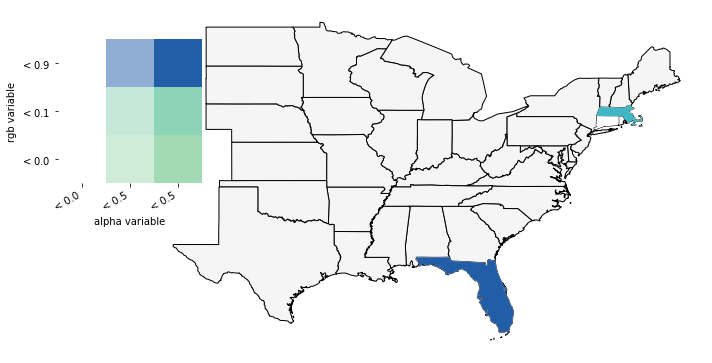

In [178]:
custom_cmap = col.LinearSegmentedColormap.from_list("", ["#8b0000","#9673A5", "#23395D"])
custom_cmap


# def make_source_sink_map(map_file, df, bins_source, bins_sink, save_name):

map_file['location'] = map_file[name_of_resolution]

with_movements = map_file.merge(df)

fig, ax = plt.subplots(1,1, figsize=(10,10))

x = with_movements["average_source"]
y = with_movements["average_sink"]

map_file.plot(ax=ax, edgecolor="black", color="whitesmoke", linewidth=1)
with_movements.plot(color="white", ax=ax)
color_list = ['#a1dab4','#41b6c4','#225ea8']
vba_choropleth(x,y, with_movements, ax=ax, cmap=color_list, rgb_mapclassify=dict(classifier="natural_breaks", k=3),
               alpha_mapclassify=dict(classifier="natural_breaks", k=3), revert_alpha=False, divergent=True,
               legend=True)


plt.show()   
#     plt.savefig(f"../figures/components/{save_name}.pdf", bbox_inches="tight")
